# MODEL (IN PROGRESS)

## DATA PROCESSING

### READER

Скрипт читает все файлы замеров и переводит замеры в словарь ```Data```, в котором ключи --- параметры железа.

Структура ```Data```: $$\left\{\begin{pmatrix}protection \\ size \\ nodes \\ w/r \\ HW\_chassis \end{pmatrix}:\;\begin{Bmatrix}MB/s: & list \\ avg: & list\\ min: & list \\ med: & list \\ max: & list \\ p(90): & list \\ p(95): & list \\ op/s: & list \\ op/s\_loss: & list \\ SUM\_MB/s: & float \\ SUM\_op/s: & float\end{Bmatrix}\right\}$$

In [5]:
import pandas as pd
import numpy as np
import re
import glob


folder_path = 'C:/Yadro/Sizes'

txt_files = glob.glob(f"{folder_path}/*.txt")
md_files = glob.glob(f"{folder_path}/*.md")

all_files = txt_files + md_files


Data = dict()

for file_path in all_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        
        ###
        lines = file.readlines()
        data = []
        for line in lines:
            data.append( line.strip().split(' ') )


        file_protection = [temp_data[0].split('=')[1].upper() for temp_data in data if 'protection' in temp_data[0]][0]
 
        file_HW_chassis = [temp_data[0].split('=')[1].upper() for temp_data in data if 'HW_chassis' in temp_data[0]][0]
  
        i = 0
        counter = 0
        print(str(data).count('###'),f'correct number of sizes {file_path}')
        # realization of data reading functions
        while i < len(data):
            
            if '###' in data[i]:
                counter += 1
                Params = dict.fromkeys(['protection', 'size', 'nodes', 'w/r', 'HW_chassis' ])
                for temp in list( Params.keys() ):
                    Params[temp] = 0
                '''
                w/r --- type: write / read
                HW_chassis --- hardware platform
                '''
                
                temp_data_0 = [k for k in data[i] if len(k) > 0]
                
                Params['protection'] = file_protection
                Params['nodes'] = int(temp_data_0[1])
                Params['w/r'] =  temp_data_0[4].lower()
                Params['HW_chassis'] = file_HW_chassis
                
                if re.fullmatch( r'(\b\d*kb\b)', str( temp_data_0[3] ).lower()):  # size like kb
                    Params['size'] = float(temp_data_0[3][:-2])
                elif re.fullmatch( r'(\b\d*kib\b)', str( temp_data_0[3] ).lower() ):  #size like kib
                    Params['size'] = float(temp_data_0[3][:-3])
                elif re.fullmatch( r'(\b\d*mb\b)', str( temp_data_0[3] ).lower() ):  #size like mb
                    Params['size'] = float(temp_data_0[3][:-2]) * 1000  # convert to KB
                elif re.fullmatch( r'(\b\d*mib\b)', str( temp_data_0[3] ).lower() ):  #size like mib
                    Params['size'] = float(temp_data_0[3][:-3]) * 1000
                else:
                    Params['size'] = 'INCORRECT DATA'
                
                i += 1
                
                Input = dict.fromkeys(['MB/s', 'avg', 'min', 'med', 'max', 'p(90)', 'p(95)','op/s','op/s_loss', 'SUM_MB/s','SUM_op/s'])
                for temp in list( Input.keys() ):
                    Input[temp] = []
                '''
                op/s_loss --- perfomance fails
                SUM_MB/s, SUM_op/s --- SUM of perfomance in MB/s, op/s
                '''

                while i < len(data) - 1 and not('###' in data[i+1]):
                    
                    if 'aws_obj_get_bytes' in str(data[i]) or 'aws_obj_put_bytes' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        if str(temp_data[-1]).lower() == 'mb/s':
                            Input['MB/s'].append(float(temp_data[-2]))
                        elif str(temp_data[-1]).lower() == 'gb/s':
                            Input['MB/s'].append(float(temp_data[-2]) * 1000)  # convert to mb/s
                        else:
                            Input['MB/s'].append('INCORRECT DATA')
                    
                    if 'aws_obj_get_duration' in str(data[i]) or 'aws_obj_put_duration' in str(data[i]):
                        temp_data = [k.split('=') for k in data[i] if len(k) > 0]
                        for j in range(1,6+1):                            
                            if 'ms' in str(temp_data[j][1]).lower():  # case M.SECONDS
                                Input[temp_data[j][0]].append(float(temp_data[j][1][:-2]))  # we suppose that notation <digits>m<digits><MS> is impossible 
                                    
                            else:  # case SECONDS 
                                match = re.fullmatch( r'(\b\d*\dm\d\d*\w*\b)', str(temp_data[j][1]).lower() )  # <digits (at least 1)>m<digits (at least 1)><s> - found m in d[b][1] in seconds
                                if match:
                                    Input[temp_data[j][0]].append((float(str(temp_data[j][1][:-1]).split('m')[0]) * 60 + float(str(temp_data[j][1][:-1]).split('m')[1])) * 1000)  # convert to ms| found m
                                else:
                                    Input[temp_data[j][0]].append(float(temp_data[j][1][:-1]) * 1000)  # convert to ms
            
                    if 'aws_obj_put_success' in str(data[i]) or 'aws_obj_get_success' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s'].append(float(temp_data[2][:-2:]))  #obj/s
                        
            
                    if 'aws_obj_get_fails' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s_loss'].append(float(temp_data[2][:-2:]))  #obj/s
                    i += 1
                ### found '###' or end of file, update our Data                    
                
                # realization of agregate functions 
                Input['SUM_MB/s'] = np.sum(Input['MB/s'])
                Input['SUM_op/s'] = np.sum(Input['op/s'])
                
                ###
                
                Data[tuple(Params.values())] = Input
            i += 1
                        
    print(counter, f'get number of sizes {file_path}')


39 correct number of sizes C:/Yadro/Sizes\Sizer results for rep3.txt
39 get number of sizes C:/Yadro/Sizes\Sizer results for rep3.txt
61 correct number of sizes C:/Yadro/Sizes\Sizer_results_1.txt
61 get number of sizes C:/Yadro/Sizes\Sizer_results_1.txt
56 correct number of sizes C:/Yadro/Sizes\sizer_results_ec2.1_retest_actual.md
56 get number of sizes C:/Yadro/Sizes\sizer_results_ec2.1_retest_actual.md


### CONVERTER

Конвертирует словарь ```Data``` в список ```Data_list```.

In [8]:
Data_list = []
for key in list(Data.keys()):
    Data_list.append(list(key) + list(Data[key].values()) )
Header = list(Params.keys())
for key in list(Data.keys()):
    Header += list(Data[key].keys())
    break

### WRITER

Записывает ```Data_list``` в .xlsx файл.

In [61]:
df = pd.DataFrame(Data_list, columns = Header)
df.to_excel('output.xlsx', index=False, header=True)

### DOCUMENTATION

Фиксируем возможные значения параметров.

In [13]:
import itertools


doc = {'protection': ['2REP', '3REP', 'EC2.1'],
       'size': [8, 128, 1e3, 128e3], 
       'nodes': np.linspace(4, 16, 13, dtype = int),
       'type': ['write', 'read'],
       'HW_chassis': ['X205'] # VEGMAN - after sizes!
      }

all_options = np.array(list(itertools.product( *(doc[key] for key in list(doc.keys())) )))

all_options_w_ops = np.concatenate((all_options, [[0] for _ in range(len(all_options))]), axis = 1)


'''
print(all_options)

print(all_options_w_ops)

print(len(all_options_w_ops))

print(len(Data))
'''

'\nprint(all_options)\n\nprint(all_options_w_ops)\n\nprint(len(all_options_w_ops))\n\nprint(len(Data))\n'

### ONE HOT ENCODER MODULE

Переводит строковые категориальные признаки в унитарные.

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


def features_transformation(Data: dict) -> pd.DataFrame:
    X = np.array([list(key) + [Data[key]['SUM_op/s']] for key in list(Data.keys())])
    Y = all_options_w_ops # massive of all posible key values, target values = 0
    X = np.vstack((X, Y))
    header = ['protection', 'size', 'nodes', 'type', 'HW_chassis', 'SUM_op/s']
    X_OHE_DF = pd.get_dummies(pd.DataFrame(X, columns = header), columns=["protection", "type", 'HW_chassis'], prefix=["protection", "type", 'HW_chassis'])
    X_OHE_DF['size'] = X_OHE_DF['size'].astype(float)
    X_OHE_DF['nodes'] = X_OHE_DF['nodes'].astype(int)
    X_OHE_DF['SUM_op/s'] = X_OHE_DF['SUM_op/s'].astype(float)
    X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
    return (X_OHE_DF.drop(['protection_2REP', 'type_read'], axis=1, inplace=False)).head(len(Data))  # drop collinear columns

#print(features_transformation(Data))


### GRAPHS (RAW DATA)

Отображает график зависимости целевого значения от параметра. Параметр может быть `size` или `nodes`.

Text(0, 0.5, 'Op per sec')

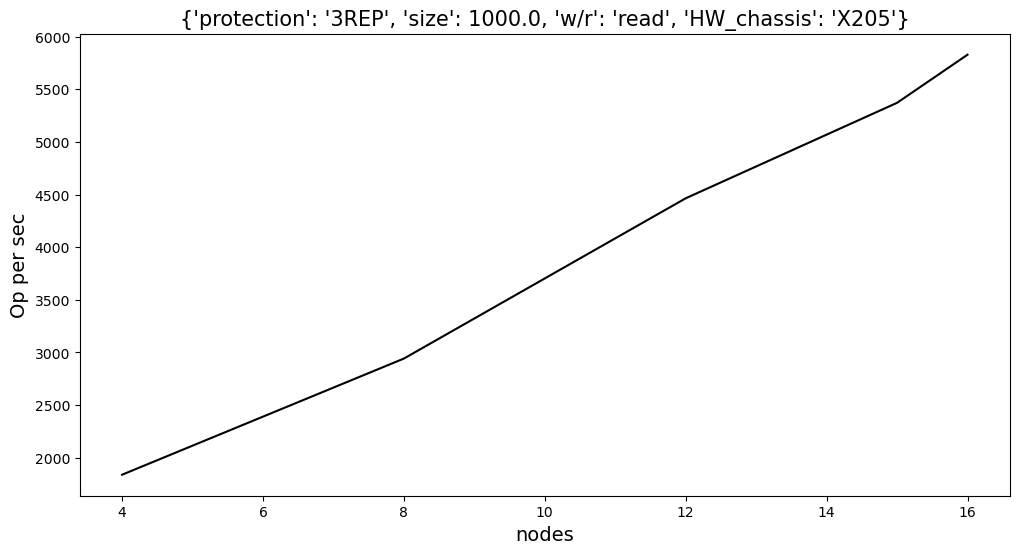

In [73]:
import matplotlib.pyplot as plt



parametr = 'nodes'   # parametr =  'size' -> key[1], 'nodes' -> key[2];
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix params for detail searching
fix_params = {
    'protection': '3REP',
    'size': 1e3,
    'nodes': 15,
    'w/r': 'read',
    'HW_chassis': 'X205'
}
###

params = ['protection', 'size', 'nodes', 'w/r', 'HW_chassis']

def enumerate(param: str) -> int:
    if param == 'protection':
        return 0
    elif param == 'size':
        return 1
    elif param == 'nodes':
        return 2
    elif param == 'w/r':
        return 3
    elif param == 'HW_chassis':
        return 4

other_params = ['NO DATA' for _ in range(len(list(Data.keys())[0]))]
other_params[enumerate('protection')] =fix_params['protection']
other_params[enumerate('HW_chassis')] = fix_params['HW_chassis']
other_params[enumerate('w/r')] = fix_params['w/r']
other_params[enumerate('size')] = fix_params['size']
other_params[enumerate('nodes')] = fix_params['nodes']

Z = np.array((
        [ key[enumerate(parametr)] for key in list(Data.keys()) if (key[(enumerate(parametr) + 1) % 5] == other_params[(enumerate(parametr) + 1) % 5] and
                                                                    key[(enumerate(parametr) + 2) % 5] == other_params[(enumerate(parametr) + 2) % 5] and
                                                                    key[(enumerate(parametr) + 3) % 5] == other_params[(enumerate(parametr) + 3) % 5] and
                                                                    key[(enumerate(parametr) + 4) % 5] == other_params[(enumerate(parametr) + 4) % 5]
                                                                   )],  # parametr
        [ Data[key]['SUM_op/s'] for key in list(Data.keys()) if (key[(enumerate(parametr) + 1) % 5] == other_params[(enumerate(parametr) + 1) % 5] and
                                                                 key[(enumerate(parametr) + 2) % 5] == other_params[(enumerate(parametr) + 2) % 5] and
                                                                 key[(enumerate(parametr) + 3) % 5] == other_params[(enumerate(parametr) + 3) % 5] and
                                                                 key[(enumerate(parametr) + 4) % 5] == other_params[(enumerate(parametr) + 4) % 5]
                                                                )]  # target value
        )).T

plt.figure(figsize=(12, 6)) 
plt.subplot(1, 1, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T

plt.plot(Z[0], Z[1],'k-', alpha = 1)


graph_title = fix_params.copy()
graph_title.pop(parametr, None)
 
plt.title(graph_title, fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')



# PREDICTION

## LINEAR REGRESSION

### THEORY

*пока написано, как есть, как только окончательно определимся с характером изменений целевого значения от каждого из параметров - изменятся харфы numerical параметров; используем лин рег из `sklearn.linear_model`*

Знаем, что $\text{target value}\;|\;\text{nodes}\sim \log (\text{nodes})$

$$\{v\,(i_0 i_1 \cdots i_4)\;|\;[size\,(i_0),\;nodes\,(i_1),\;protection\,(i_2),\;type\,(i_3),\;HW\_chassis\,(i_4) ]\} - \text{size}$$

Матрица признаков:

$$X = \begin{pmatrix}
[size\,(0),\;nodes\,(0),\;protection\,(0),\;type\,(0),\;HW\_chassis\,(0) ]^\top \\
\vdots \\
[size\,(0),\;nodes\,(0),\;protection\,(0),\;type\,(0),\;HW\_chassis\,(d_4) ]^\top \\
[size\,(0),\;nodes\,(0),\;protection\,(0),\;type\,(1),\;HW\_chassis\,(0) ]^\top \\
\vdots \\
[size\,(d_0),\;nodes\,(d_1),\;protection\,(d_2),\;type\,(d_3),\;HW\_chassis\,(d_4) ]^\top
\end{pmatrix}$$

Введём для `numerical` параметров - `nodes, size` - базисные функции:



$$\boldsymbol{\phi}_{size}(s) = \begin{pmatrix}
e^{-(s - 8)^2 / 2e4}\\
e^{-(s - 128)^2 / 2e4}\\
e^{-(s - 1e3)^2 / 2e4}\\
e^{-(s - 128e3)^2 / 2e4}\\
1\\
s\\
e^{-s}\\
e^{-s^2}
\end{pmatrix}\in R^{8};\;\boldsymbol{\phi}_{nodes}(n) = \begin{pmatrix}
\log(n)\\
1\\
n
\end{pmatrix}\in R^3$$

$$\boldsymbol{\phi}(n,\,s) = (\;\boldsymbol{\phi}_{nodes}(n)_i\cdot \boldsymbol{\phi}_{size}(s)_j\;)_{(i,j)}\in R^{24}$$

Для `categorial` параметров - `protection, type, HW_chassis` - One Hot Encoder


Таким образом, модель приняла вид:

$$\hat{v}\,(i_0\,i_1\,\cdots\,i_4) = \boldsymbol{w}^\top \begin{pmatrix}
\boldsymbol{\phi}(nodes\,(i_1),\,size\,(i_0))\\
\boldsymbol{\text{OHE}}(protection\,(i_2),\;type\,(i_3),\;HW\_chassis\,(i_4))
\end{pmatrix}$$

где $\boldsymbol{\text{OHE}}$ - кодирование наших `cat.` параметров.



### REALIZATION

Скрипт обучения модели и предобработки данных.

**DATA PREPROCESSING**

Подготавливаем данные к обучению.

In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

# X: [0]: <size>, [1]: <nodes>, [2 <= n]: <cat.>


def size_transformation(X: np.ndarray) -> np.ndarray:
    #mu_size = np.concatenate((np.linspace(1, 1e3, 7), [128e3]))
    mu_size = [8, 128, 1e3, 128e3]
    sigma_size = 2e2
    #sigma_size = [10, 10, 1e1, 1e1]
    X = X.T
    return np.concatenate([
        [
            np.exp(-(X - mu_size[i]) ** 2 / sigma_size ** 2) for i in range(0, 4)
        ] + # size' gaussians
        [
            X ** i for i in range(0, 2)
        ] + # size' poly
        [
            np.exp(-X ** i) for i in range(1, 3)
        ]
    ]).T

def nodes_transformation(X: np.ndarray) -> np.ndarray:
    X.T
    return np.concatenate([
        [
            np.log(X) ** k for k in range(1, 2)
        ] + # nodes' log
        [
            X ** k for k in range(0, 2)
        ] # nodes' poly
    ]).T

def nodes_cross_size_transformation(nodes: np.ndarray, size: np.ndarray) -> np.ndarray:
    nodes.T; size.T
    cross = []
    for x, y in zip(nodes, size):
        z = []
        z.append(1)
        for i in x:
            for j in y:
                z.append( i * j )
        cross.append(z)
    return np.array(cross)




def phi(Data: dict) -> (np.ndarray, np.ndarray):
    raw_features = features_transformation(Data)
    categorial = np.array(raw_features.drop(columns=['size', 'nodes', 'SUM_op/s']))
    target = np.array(raw_features['SUM_op/s'])
    features = np.concatenate(
        (
            nodes_cross_size_transformation(
                nodes_transformation(np.array(raw_features['nodes'])),
                size_transformation(np.array(raw_features['size']))
            ),
            #size_transformation(np.array(raw_features['size'])),
            #nodes_transformation(np.array(raw_features['nodes'])),
            categorial
        ), axis = 1
    )
    return (features, target)



**TRAIN**

Обучаем нашу модель

In [85]:

X = phi(Data)[0]  # predictors 

Y = phi(Data)[1]  # target

X_x_Y = np.column_stack([X,Y])

X_x_Y_bootstrap = []

for i in np.random.choice(np.linspace(0, len(X_x_Y)-1, len(X_x_Y), dtype = int), size = int(1e5)):
    X_x_Y_bootstrap.append( X_x_Y[i] )

X_x_Y_bootstrap = np.array(X_x_Y_bootstrap)





X_train_LR, X_test_LR, Y_train_LR, Y_test_LR = train_test_split(
    X_x_Y_bootstrap[:, :-1], 
    X_x_Y_bootstrap[:, -1], 
    test_size = .7, 
    random_state = 28
)
'''
generate train set from our Data
'''

sc = StandardScaler()
#sc = MinMaxScaler()


sc.fit(X_train_LR[:, :-4])

X_train_LR = np.concatenate(
    (sc.transform(X_train_LR[:, :-4]), X_train_LR[:, -4:]), axis = 1
)
X_test_LR = np.concatenate(
    (sc.transform(X_test_LR[:, :-4]), X_test_LR[:, -4:]), axis = 1
)



#M = ARDRegression()
M = LinearRegression(fit_intercept = False)
#M = Ridge(alpha = .5)
#M = grid_search.best_estimator_
#M  = Lasso(alpha = 10)
M.fit(X_train_LR, Y_train_LR) 
print('Weight matrix:',M.coef_)

n = len(list(Data.keys()))
k = len(list(Data.keys())[0])

### Linear Regression
LR_train_MSE = round(mean_squared_error(Y_train_LR, M.predict(X_train_LR)), 3)
LR_train_R2_adj = round(1 - (1- r2_score(Y_train_LR, M.predict(X_train_LR)) ) * (n - 1) / (n - k - 1), 3)
LR_test_MSE = round(mean_squared_error(Y_test_LR, M.predict(X_test_LR)), 3)
LR_test_R2_adj = round(1 - (1- r2_score(Y_test_LR, M.predict(X_test_LR)) ) * (n - 1) / (n - k - 1), 3)
###


LR_results = pd.DataFrame(['Linear regression', LR_train_MSE, LR_train_R2_adj, LR_test_MSE, LR_test_R2_adj]).transpose()
LR_results.columns = ['Method', 'Training MSE', 'Training R2_ad', 'Test MSE', 'Test R2_ad']


print('**Metrics**: \n', LR_results)

C:\Users\shiri\AppData\Local\Temp\ipykernel_14012\753302673.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_14012\753302673.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


Weight matrix: [ 9.34157939e-15  1.08055487e+14  6.13926009e+13  1.33133816e+14
  4.85755727e+13 -6.38844202e+13  8.73543766e+13 -9.69694164e+14
  9.55858060e+14 -1.97493400e+15 -4.76945390e+15 -6.03025679e+15
 -6.28396522e+15 -4.63655321e+12  1.39607781e+14 -2.28140253e+14
 -5.72007286e+14 -5.17555093e+13 -4.46849706e+14 -4.55781598e+14
 -1.21710132e+14  3.81963844e+14 -3.43912779e+14 -1.12495986e+15
  1.01541032e+15 -2.37890625e+01 -2.44831042e+03 -2.78522461e+03
  6.52483594e+03]
**Metrics**: 
               Method Training MSE Training R2_ad     Test MSE Test R2_ad
0  Linear regression  4095769.318          0.812  4036699.864      0.812


**GRAPHS (RAW & PREDICTED DATA)**

Скрипт для визуальной оценки качества модели (смотрим насколько графики близки).

C:\Users\shiri\AppData\Local\Temp\ipykernel_14012\753302673.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_14012\753302673.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


pred =  [[4.000000e+00 1.527500e+03]
 [5.000000e+00 2.819500e+03]
 [6.000000e+00 3.954625e+03]
 [7.000000e+00 4.982250e+03]
 [8.000000e+00 5.931500e+03]
 [9.000000e+00 6.821000e+03]
 [1.000000e+01 7.663000e+03]
 [1.100000e+01 8.471000e+03]
 [1.200000e+01 9.239000e+03]
 [1.300000e+01 9.982000e+03]
 [1.400000e+01 1.071000e+04]
 [1.500000e+01 1.140400e+04]
 [1.600000e+01 1.209600e+04]]
raw =  [[4.00000000e+00 6.68752753e+02]
 [8.00000000e+00 4.93572912e+03]
 [1.20000000e+01 7.23654449e+03]
 [1.60000000e+01 9.68055470e+03]]


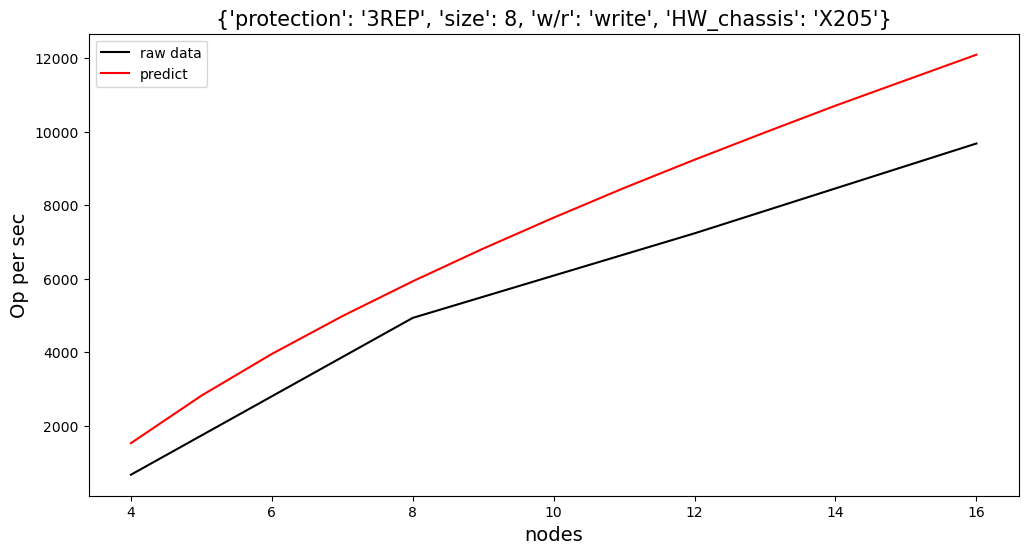

In [56]:
import matplotlib.pyplot as plt


parametr = 'nodes'   # parametr =  'size' -> key[1], 'nodes' -> key[2];
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix params for detail searching
fix_params = {
    'protection': '3REP',
    'size': 8,
    'nodes': 8,
    'w/r': 'write',
    'HW_chassis': 'X205'
}
###


###
target_params = [ fix_params.copy() for _ in range(len(doc[parametr])) ]


for i in range(len(doc[parametr])):
    target_params[i][parametr] = doc[parametr][i]

#print('t_p',target_params, '\n')
    
target_keys = [ tuple(x.values()) for x in target_params ]

target_values = [ Data[key]['SUM_op/s'] for key in target_keys if key in list(Data.keys())]
###



###
Z = np.array((
    [ x[parametr] for x in target_params if  tuple(x.values()) in list(Data.keys())],
    target_values
)).T

#print(Z)

Data_t = {key: {'SUM_op/s': 0} for key in target_keys}

#print(target_params)


#print(features_transformation(Data_t))

#print('phi',phi(Data_t)[0], '\n')




#print(target_keys, '\n', target_values)



#print(Data_t, '\n')

'''
print(phi(Data_t))

print(
    np.array((
    M.predict(phi(Data_t)[0])
)).T
)

print(
    np.array((
    [ x[parametr] for x in target_params]
)).T
)
'''




Z_pred = np.array((
    [ x[parametr] for x in target_params],
    M.predict(np.concatenate(
    (sc.transform(phi(Data_t)[0][:, :-4]), phi(Data_t)[0][:, -4:]), axis = 1
)) * 1
)).T

print('pred = ',Z_pred)

print('raw = ', Z)



'''
print('raw phi', phi(Data_t)[0][:2])

print('normed phi',np.concatenate(
    (sc.transform(phi(Data_t)[0][:, :-4]), phi(Data_t)[0][:, -4:]), axis = 1
)[:2])
'''


plt.figure(figsize=(12, 6)) 
plt.subplot(1, 1, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T

Z_pred = Z_pred[Z_pred[:, 0].argsort()].T


plt.plot(Z[0], Z[1],'k-', alpha = 1, label = 'raw data')

plt.plot(Z_pred[0], Z_pred[1],'r-', alpha = 1, label = 'predict')


graph_title = fix_params.copy()
graph_title.pop(parametr, None)
 
plt.title(graph_title, fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')
plt.legend()
